# Spotify Sequential Skip Prediction Challenge

### Anna Martignano, Daniele Montesi, ID2221
With  this  project  we  would  like  to  use  Deep  Learning  to  model  a  solution  to  the  challenge  ”  Spotify Sequential  Skip  Prediction  Challenge  -  Predict  if  users  will  skip  or  listen  to  the  music  they’re  streamed” published by Spotify in collaboration with WSDM and CrowdAI.

Citing the CrowdAI Challenge Website:The task is to predict whether individual tracks encountered in a listening session will beskippedby a particular user.  In order to do this, complete information about the first half of a user’slistening session is provided, while the prediction is to be carried out on the second half.  

The output of a prediction is abinary variable for each track in the second half of the session indicating if it was skipped or not, with a 1 indicating that the track skipped, and a 0 indicating that the track was not skipped.The  problem  corresponds  hence  to  a  binary  classification.   However,  the  problem  is  hard  and  must take into account all the history of the user tracks listened, making the model that best fits this problem aRecurrent Neural Networks.


### Code organization


The problem will present the following sections:

1. Data exploration 
2. Data filtering/preprocessing 
3. Dataset creation
4. Model reasoning and creation and fitting (First Baseline)
5. Model validation: CV / test/train/valid
6. (Optional): Further feature extraction and further model improvement
    - 

## 1 - Data Exploration

Let's perform basic data esploraton to see which types of columns to leave/to remove

We will start form the session dataset:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
from joblib import delayed, Parallel
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GroupKFold, KFold
%matplotlib inline
pd.set_option('display.max_columns', 500)

### Useful paths

In [2]:
path = "dataset/"
project_path = "C:/Users/AnnaM/OneDrive/EIT/KTH/SML&DL/scalable-machine-learning-deep-learning/Project"
train_path = project_path + "/Dataset/training_set"
features_path = project_path + "/Dataset/track_features"

The dataset is made of the first 6 csv blocks provided by AICrowd. Each block is ~500MB size csv. For sake of brevity, we only explore one small dataset block here.

Let's now explore the first block and how it does look like:

In [8]:
"""
data = pd.read_csv(path+"{}.csv".format(1))

list_batches = [2,3,4,5,6]
for num in list_batches[:1]:
    data = pd.concat([data, pd.read_csv(path+"{}.csv".format(num))])
    
data.reset_index(drop=True, inplace=True)
"""

'\ndata = pd.read_csv(path+"{}.csv".format(1))\n\nlist_batches = [2,3,4,5,6]\nfor num in list_batches[:1]:\n    data = pd.concat([data, pd.read_csv(path+"{}.csv".format(num))])\n    \ndata.reset_index(drop=True, inplace=True)\n'

In [9]:
data = pd.read_csv(train_path+"/log_0_20180715_000000000000.csv")
data = pd.concat([data, pd.read_csv(train_path+"/log_0_20180716_000000000000.csv")])
    
data.reset_index(drop=True, inplace=True)

In [10]:
data.head(5)

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone


In [11]:
data.session_length.value_counts(normalize=True, sort=False)

10    0.049730
11    0.047802
12    0.046299
13    0.043943
14    0.042139
15    0.040091
16    0.037159
17    0.035287
18    0.032769
19    0.031109
20    0.593671
Name: session_length, dtype: float64

In [12]:
data.skip_2.value_counts(normalize=True, sort=False)

False    0.493206
True     0.506794
Name: skip_2, dtype: float64

In [14]:
data.hist_user_behavior_reason_start.value_counts(normalize=True, sort=False)

trackdone     3.373189e-01
backbtn       7.640903e-02
fwdbtn        4.700385e-01
playbtn       9.196412e-04
appload       1.161035e-02
clickrow      1.020756e-01
endplay       1.153077e-04
uriopen       1.566680e-07
remote        9.227746e-04
popup         1.566680e-06
clickside     1.566680e-07
trackerror    5.879750e-04
Name: hist_user_behavior_reason_start, dtype: float64

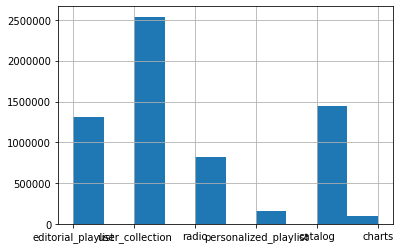

In [15]:
data.context_type.hist()

In [16]:
data.no_pause_before_play.value_counts(normalize=True, sort=False)

0    0.233884
1    0.766116
Name: no_pause_before_play, dtype: float64

In [17]:
data.premium.value_counts()

True     5169495
False    1213429
Name: premium, dtype: int64

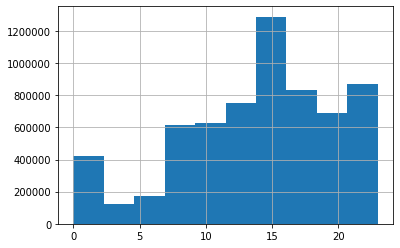

In [18]:
data.hour_of_day.hist()

In [19]:
data.hist_user_behavior_reason_start.value_counts()

fwdbtn        3000220
trackdone     2153081
clickrow       651541
backbtn        487713
appload         74108
remote           5890
playbtn          5870
trackerror       3753
endplay           736
popup              10
clickside           1
uriopen             1
Name: hist_user_behavior_reason_start, dtype: int64

In [20]:
data.describe()

,session_position,session_length,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hour_of_day
count,6.382924e+06,6.382924e+06,6.382924e+06,6.382924e+06,6.382924e+06,6.382924e+06,6.382924e+06,6.382924e+06,6.382924e+06
mean,9.295027e+00,1.759005e+01,4.128312e-02,7.661164e-01,1.472823e-01,1.741041e-01,4.134328e-02,4.346221e-02,1.395402e+01
std,5.442107e+00,3.427399e+00,1.989443e-01,4.232990e-01,3.543872e-01,3.791990e-01,3.671143e-01,4.799101e-01,5.849692e+00
min,1.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,1.500000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01
50%,9.000000e+00,2.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01
75%,1.400000e+01,2.000000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.800000e+01
max,2.000000e+01,2.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.200000e+02,4.380000e+02,2.300000e+01


## Let's now explore those particular features:  

- (1) the number of times the specific song appeared within the same session, 
- (2) the number of unique songs in this session, and 
- (3) the number of times the specific song appeared over all sessions

If interesting, we are then going to feature-engineer those interesting features, and we log-normalised the last feature in order to alleviate the long tail distribution.

In [21]:
data.head(50)

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone
5,0_00006f66-33e5-4de7-a324-2d18e439fc1e,6,20,t_c815228b-3212-4f9e-9d4f-9cb19b248184,False,False,True,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,fwdbtn
6,0_00006f66-33e5-4de7-a324-2d18e439fc1e,7,20,t_e23c19f5-4c32-4557-aa44-81372c2e3705,True,True,True,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,fwdbtn,fwdbtn
7,0_00006f66-33e5-4de7-a324-2d18e439fc1e,8,20,t_0be6eced-f56f-48bd-8086-f2e0b760fdee,True,True,True,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,fwdbtn,fwdbtn
8,0_00006f66-33e5-4de7-a324-2d18e439fc1e,9,20,t_f3ecbd3b-9e8e-4557-b8e0-39cfcd7e65dd,False,True,True,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,fwdbtn,fwdbtn
9,0_00006f66-33e5-4de7-a324-2d18e439fc1e,10,20,t_2af4dfa0-7df3-4b7e-b7ab-353ba48237f9,True,True,True,False,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,fwdbtn,fwdbtn


In [22]:
# Check for presence of duplicate tracks into a session
grouped_sess_tracks = data.groupby('session_id')['track_id_clean'].apply(lambda x: x.tolist()).tolist()

In [23]:
dict_dup_tracks = {}

dup_track_in_sess = 0
dup = 0

idx = 0
for list_tracks in tqdm(grouped_sess_tracks):
    curr_sess = data.at[idx, "session_id"]
    dict_dup_tracks[curr_sess] = {}
    
    tot_len = len(list_tracks)
    len_set = len(set(list_tracks))
    if tot_len > len_set:
        dup_track_in_sess += 1
        dup += tot_len-len_set
        
    for track in list_tracks:
        if dict_dup_tracks.get(track) == None:
            dict_dup_tracks[curr_sess][track] = 1
        else:
            dict_dup_tracks[curr_sess][track] +=1
            
    idx += tot_len
    
print("There are", dup_track_in_sess*100/len(grouped_sess_tracks), "% sessions presenting at least a duplicate track suggested")

print("On avg, there are", dup/len(grouped_sess_tracks), "duplicate songs in those sessions")

100%|███████████████████████████████████████████████████████████████████████| 381567/381567 [00:08<00:00, 45082.36it/s]

There are 54.82575799269853 % sessions presenting at least a duplicate track suggested
On avg, there are 2.1475258604648726 duplicate songs in those sessions


55% of sessions are recommended a track multiple times. It will be interesting to add this feature in the future processing of data

In [24]:
for i in tqdm(data.index):
    data.at[i, 'duplicated_time'] = dict_dup_tracks[data.at[i, 'session_id']][data.at[i, 'track_id_clean']]

100%|█████████████████████████████████████████████████████████████████████| 6382924/6382924 [05:54<00:00, 18002.68it/s]


In [25]:
data.head()

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end,duplicated_time
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,20,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,False,False,False,True,0,0,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,1.0
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,20,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,1.0
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,20,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,1.0
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,20,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,1.0
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,20,t_64f3743c-f624-46bb-a579-0f3f9a07a123,False,False,False,True,0,1,0,0,0,0,True,16,2018-07-15,True,editorial_playlist,trackdone,trackdone,1.0


### Tracks dataset:

Also, let's load the Tracks features and explore them


In [30]:
tf = pd.read_csv(features_path+"/tf_0.csv")
tf = pd.concat([tf, pd.read_csv(features_path+"/tf_1.csv")])
tf.reset_index(drop=True, inplace=True)

In [31]:
tf.sample(5)

,track_id,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,mode,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
2225918,t_2419cf76-0cf1-4278-b686-f84fd2f5ece4,240.866669,2018,96.471123,0.141489,0.445904,0.460212,0.571019,7.366660,0.694800,0.913730,8.739103e-09,1,0.552296,-11.167,0.323810,major,0.488494,0.247261,88.594002,4,0.742285,-0.868940,0.220851,0.164465,0.179780,-0.369535,-0.113078,-0.596541,0.201054
848479,t_7b64cdc1-de8f-4f11-ae0b-6c75ae249953,178.506668,2011,91.986576,0.184078,0.531010,0.547927,0.739689,8.221137,0.945517,0.975522,7.248434e-06,5,0.126412,-0.993,0.827586,major,0.178342,0.041666,124.967003,4,0.831385,-0.399625,0.237060,0.302790,0.443778,-0.103646,0.183239,0.858307,-0.062886
2969370,t_5b89bae4-84f9-4609-ad93-5ee8bddd7c9d,262.359985,2006,98.631880,0.481223,0.628292,0.702012,0.778145,10.659864,0.883593,0.845731,1.363781e-01,7,0.115634,-8.671,0.861290,major,0.354130,0.919156,160.061005,4,0.787738,0.065652,-0.088661,-0.060772,-0.237535,-0.258828,0.117019,-0.262842,0.245300
64951,t_a476893c-cb87-4a70-97ef-a372a7173b77,195.906677,2008,97.603482,0.462313,0.569181,0.648601,0.717947,9.965310,0.430603,1.036914,3.133417e-04,0,0.316132,-8.498,0.435000,major,0.516216,0.030920,137.949997,4,0.803527,-0.182034,-0.089838,0.092897,0.507148,0.462315,-0.229210,0.465023,-0.493590
2109585,t_9bc94619-3dab-461e-9c39-7c2ac0cec628,207.826675,2007,90.272929,0.137271,0.695124,0.732769,0.832636,10.658015,0.647803,1.006568,3.198863e-08,1,0.284948,-6.804,0.824503,major,0.157547,0.152064,97.008003,4,0.781647,-0.902959,0.349198,0.195230,0.181569,-0.226343,-0.105787,-0.341253,0.082466


In [32]:
tf.describe()

,duration,release_year,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,key,liveness,loudness,mechanism,organism,speechiness,tempo,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
count,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06,3.706388e+06
mean,2.331915e+02,2.009261e+03,9.557394e+01,3.469715e-01,4.617475e-01,4.791122e-01,5.565486e-01,7.848266e+00,5.918491e-01,9.934531e-01,2.070054e-01,5.272434e+00,2.126515e-01,-9.604988e+00,4.996207e-01,4.618936e-01,1.045310e-01,1.200684e+02,3.874560e+00,4.814764e-01,-1.044815e-01,1.553606e-02,5.953425e-02,5.320778e-02,2.273738e-02,6.459076e-04,-2.493560e-02,-1.594925e-03
std,1.084008e+02,1.103289e+01,2.735566e+00,3.426439e-01,1.717593e-01,1.990264e-01,1.858440e-01,2.680296e+00,2.602815e-01,5.521685e-02,3.447905e-01,3.564020e+00,1.924461e-01,5.732654e+00,2.561809e-01,2.509198e-01,1.385980e-01,3.042757e+01,4.851897e-01,2.725142e-01,4.323750e-01,3.607428e-01,2.804066e-01,3.821163e-01,4.107566e-01,2.118570e-01,3.742747e-01,3.871178e-01
min,3.000095e+01,1.950000e+03,9.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-6.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.174042e+00,-1.185975e+00,-8.858698e-01,-8.994451e-01,-1.081056e+00,-1.063290e+00,-8.022487e-01,-1.178501e+00
25%,1.767467e+02,2.006000e+03,9.338183e+01,2.667680e-02,3.316528e-01,3.206987e-01,4.326980e-01,5.821963e+00,4.098319e-01,9.691408e-01,2.465405e-07,2.000000e+00,9.680310e-02,-1.171000e+01,2.692308e-01,2.532349e-01,3.627243e-02,9.603400e+01,4.000000e+00,2.519543e-01,-4.085117e-01,-1.757177e-01,-1.471524e-01,-2.348342e-01,-3.122829e-01,-9.018810e-02,-3.155564e-01,-2.704680e-01
50%,2.179135e+02,2.013000e+03,9.575417e+01,2.205129e-01,4.593159e-01,4.795972e-01,5.727441e-01,7.519920e+00,6.261150e-01,1.002422e+00,2.161874e-04,5.000000e+00,1.294195e-01,-8.084000e+00,4.854369e-01,4.549237e-01,5.012670e-02,1.199480e+02,4.000000e+00,4.736025e-01,-4.000132e-02,8.460746e-02,1.291028e-01,6.207571e-02,-1.709655e-02,4.277601e-02,-9.838638e-02,-4.027091e-03
75%,2.671733e+02,2.017000e+03,9.792122e+01,6.528423e-01,5.851562e-01,6.339014e-01,6.975901e-01,9.476902e+00,8.073052e-01,1.029172e+00,3.132863e-01,8.000000e+00,2.700362e-01,-5.791000e+00,7.173145e-01,6.480055e-01,1.015356e-01,1.398600e+02,4.000000e+00,7.050039e-01,1.915962e-01,2.832876e-01,2.746523e-01,2.832823e-01,3.724048e-01,1.476096e-01,2.058770e-01,2.218316e-01
max,1.799999e+03,2.019000e+03,1.000000e+02,9.957964e-01,9.999525e-01,9.862775e-01,9.978067e-01,5.261309e+01,9.999841e-01,1.167801e+00,9.999964e-01,1.100000e+01,1.000000e+00,6.275000e+00,1.000000e+00,9.791129e-01,9.705799e-01,2.499870e+02,5.000000e+00,9.999900e-01,1.000457e+00,8.624035e-01,6.509755e-01,1.202726e+00,1.000955e+00,4.130149e-01,1.092165e+00,1.204228e+00


Total durations are 1006437


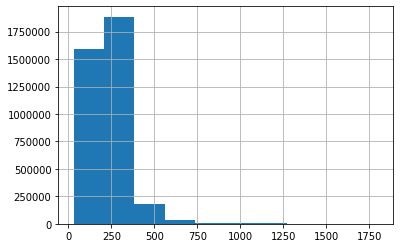

In [33]:
tf.duration.hist();
print("Total durations are", len(set(tf.duration)))

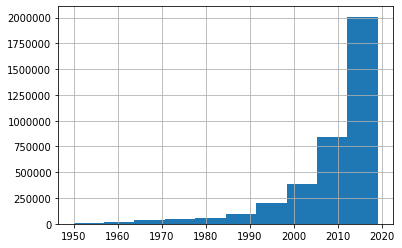

In [34]:
tf.release_year.hist();
# Similar to inverse power law distribution :)

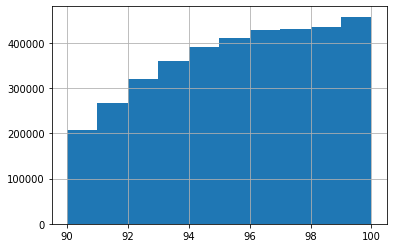

In [35]:
tf.us_popularity_estimate.hist();

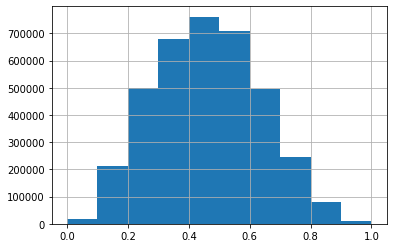

In [36]:
tf.beat_strength.hist();
# So that's a case of gaussian distribution :)

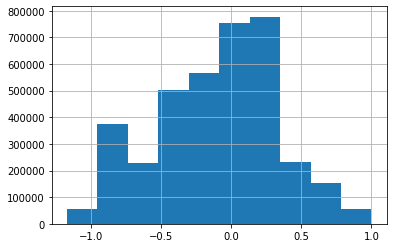

In [37]:
tf.acoustic_vector_0.hist();

There are 7 acoustic vector features, all looking like very similar. For the sake of comprehension in this project, We decide not to consider those feature and to drop them in the immediate

In [38]:
tf.drop(["acoustic_vector_0", 'acoustic_vector_1', "acoustic_vector_2", 'acoustic_vector_3', "acoustic_vector_4", 'acoustic_vector_5', "acoustic_vector_6", 'acoustic_vector_7'], axis=1, inplace=True)

# 2- Dataset Preprocessing

As we can see, the dataset is made of these columns:

- SessionPosition: the position of the track on the session (which can be long up to 20)
- skip_1	skip_2	skip_3	not_skipped: The possible values for skipping. For this purpose, we will drop all of these except for the skip_2, which is the type of skip we are interested on

In [39]:
data["label"] = data["skip_2"]
data.drop(['skip_1', 'skip_2','skip_3', 'not_skipped'], axis=1, inplace=True)

### Feature Engineering:  
- hour of day -> only 4 values: night-morning-after-evening
- session length - max - med - low


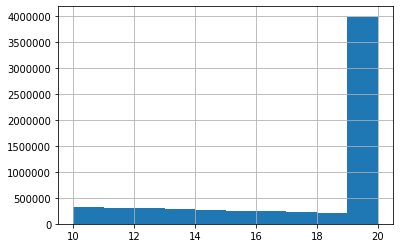

In [40]:
data.session_length.hist()

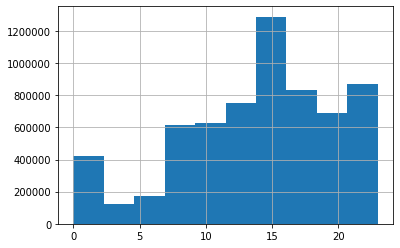

In [41]:
data.hour_of_day.hist()

In [42]:
for i in tqdm(data.index):
    leng = int(data.at[i, "session_length"])
    hour = int(data.at[i, "hour_of_day"])
    if leng < 15:
        data.at[i, "session_length"] = 0
    elif leng >= 15 and leng<20:
        data.at[i, "session_length"] = 1
    else:
        data.at[i, "session_length"] = 2
        
        
    if hour >7 and hour<=13:
        hour = data.at[i, "hour_of_day"] = 0
    elif hour >13 and hour<20:
        hour = data.at[i, "hour_of_day"] = 1
    elif hour >=20:
        hour = data.at[i, "hour_of_day"] = 2
    else:
        hour = data.at[i, "hour_of_day"] = 3   

100%|█████████████████████████████████████████████████████████████████████| 6382924/6382924 [07:39<00:00, 13879.51it/s]


In [43]:
for i in tqdm(tf.index):
    yr = int(tf.at[i, "release_year"])
    if yr < 1960:
        tf.at[i, "release_year"] = 0
    elif yr >= 1960 and yr < 1970:
        tf.at[i, "release_year"] = 1
    elif yr > 1970 and yr <= 1980:
        tf.at[i, "release_year"] = 2
    elif yr > 1980 and yr <= 1990:
        tf.at[i, "release_year"] = 3
    elif yr > 1990 and yr <= 2000:
        tf.at[i, "release_year"] = 4
    elif yr > 2000 and yr <= 2005:
        tf.at[i, "release_year"] = 5
    elif yr > 2005 and yr <= 2010:
        tf.at[i, "release_year"] = 6
    elif yr > 2010 and yr <= 2015:
        tf.at[i, "release_year"] = 7
        

100%|█████████████████████████████████████████████████████████████████████| 3706388/3706388 [01:46<00:00, 34835.03it/s]


### Scaling and one-hot-encoding

In [44]:
# Generate dummy columns for categorical variables
# Scaler
print('{0}\t\tNormalising context features...'.format(datetime.datetime.now()))
features = list(set(data.columns) - set(['session_id','track_id_clean','date', 'label', 'session_position', 'train_flag', "context_switch", 'session_length', 'no_pause_before_play','short_pause_before_play','long_pause_before_play','hist_user_behavior_n_seekfwd','hist_user_behavior_is_shuffle','premium','hour_of_day', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end', 'session_length', 'context_type']))
data[features] = StandardScaler().fit_transform(data[features])

features_t = list(set(tf.columns) - set(['track_id' , 'release_year', 'time_signature', 'mode', 'key']))
tf[features_t] = StandardScaler().fit_transform(tf[features_t])

features.append('label')
features.append('session_position')

print('{0}\t\tOne-hot-encoding categorical variables...'.format(datetime.datetime.now()))
data = pd.get_dummies(data, columns = ['context_type'], prefix = ['context_type'])
data = pd.get_dummies(data, columns = ['hist_user_behavior_reason_start'], prefix = ['hist_user_behavior_reason_start'])
data = pd.get_dummies(data, columns = ['hist_user_behavior_reason_end'], prefix = ['hist_user_behavior_reason_end'])
data = pd.get_dummies(data, columns = ['session_length'], prefix = ['session_len'])
data = pd.get_dummies(data, columns = ['hour_of_day'], prefix = ['hour_of_day'])
# Features to use

tf = pd.get_dummies(tf, columns = ['release_year'], prefix = ['rel_year'])
tf = pd.get_dummies(tf, columns = ['mode'], prefix = ['mode'])
tf = pd.get_dummies(tf, columns = ['key'], prefix = ['key'])
tf = pd.get_dummies(tf, columns = ['time_signature'], prefix = ['time_signature'])


2020-01-05 23:10:42.409418		Normalising context features...
2020-01-05 23:10:56.603596		One-hot-encoding categorical variables...


In [45]:
data.head()

,session_id,session_position,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,date,premium,duplicated_time,label,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_clickside,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_popup,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_start_uriopen,hist_user_behavior_reason_end_appload,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_clickside,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_popup,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone,hist_user_behavior_reason_end_uriopen,session_len_0,session_len_1,session_len_2,hour_of_day_0,hour_of_day_1,hour_of_day_2,hour_of_day_3
0,0_00006f66-33e5-4de7-a324-2d18e439fc1e,1,t_0479f24c-27d2-46d6-a00c-7ec928f2b539,0,0,0,0,0,-0.090563,True,2018-07-15,True,0.0,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
1,0_00006f66-33e5-4de7-a324-2d18e439fc1e,2,t_9099cd7b-c238-47b7-9381-f23f2c1d1043,0,1,0,0,0,-0.090563,True,2018-07-15,True,0.0,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
2,0_00006f66-33e5-4de7-a324-2d18e439fc1e,3,t_fc5df5ba-5396-49a7-8b29-35d0d28249e0,0,1,0,0,0,-0.090563,True,2018-07-15,True,0.0,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
3,0_00006f66-33e5-4de7-a324-2d18e439fc1e,4,t_23cff8d6-d874-4b20-83dc-94e450e8aa20,0,1,0,0,0,-0.090563,True,2018-07-15,True,0.0,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0
4,0_00006f66-33e5-4de7-a324-2d18e439fc1e,5,t_64f3743c-f624-46bb-a579-0f3f9a07a123,0,1,0,0,0,-0.090563,True,2018-07-15,True,0.0,False,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0


In [46]:
tf.head()

,track_id,duration,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,liveness,loudness,mechanism,organism,speechiness,tempo,valence,rel_year_0,rel_year_1,rel_year_2,rel_year_3,rel_year_4,rel_year_5,rel_year_6,rel_year_7,rel_year_1970,rel_year_2016,rel_year_2017,rel_year_2018,rel_year_2019,mode_major,mode_minor,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,t_2e8f4b71-8a0b-4b9c-b7d8-fb5208e87f9f,0.856284,1.465490,1.077614,-0.554568,-0.736122,-0.628021,-0.762040,-1.356233,0.312354,1.294643,2.892270,-1.306378,-1.172806,1.186853,-0.509320,-0.647385,-0.947037,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,t_dae2ec0e-ec7b-4b3e-b60c-4a884d0eccb0,-0.787615,0.620747,1.437319,-0.579504,-0.448599,-0.263491,-0.374152,-0.658415,0.125777,-0.600380,-0.658925,-0.294805,-0.554225,1.137982,-0.394488,0.698894,0.011838,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,t_cf0164dd-1531-4399-bfa6-dec19cd1fedc,-1.132754,1.479198,-0.853069,0.193611,0.554028,-0.022801,0.564745,0.964682,-0.646311,-0.298285,1.011572,0.051457,-0.760789,0.124583,-0.236493,0.618572,1.236503,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,t_0f90acc7-d5c5-4e53-901d-55610fbd090c,0.041161,0.447034,-0.888284,-0.419852,-0.603277,0.156714,-0.663989,0.282576,-0.835452,-0.600339,0.201875,-0.445520,0.793686,-0.995125,-0.541900,0.429566,0.415951,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,t_36b9ad02-095a-443d-a697-6c7285d9410a,-0.540507,0.852457,-0.283062,0.302126,0.031767,0.422646,-0.242335,-0.703599,0.373244,0.927179,0.029712,-0.734043,1.519506,-1.069886,-0.522034,1.056399,0.402963,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


# 3- Dataset Creation

The dataset is formed analogously to whast reported in the 5th place solution paper: http://adrem.uantwerpen.be//bibrem/pubs/WSDMCupJeunen2019.pdf

![alt test](pics/model.png)

(https://github.com/olivierjeunen/sequential-skip-prediction/blob/master/src/RNN.py in generate_model() )

where Xh and Xf are respectively 2 matrices for the session history and future. 
### The steps to the dataset creation are:

1. Merge track features and session features
2. Split based on the time, and drop that feature (with other useless features)
3. create the History-Matrix and Future Matrix. Create duplicate files for each new song to predict its label 

## Keep only tracks present in the training set

Then, we will explore how frequent they are :)

In [47]:
set_tracks_present = set(data.track_id_clean.values)
tracks_set = set(tf.track_id)
print("There are", len(set_tracks_present), "tracks in the dataset \nInstead, in the tracks_data there are", len(tracks_set) )

There are 490935 tracks in the dataset 
Instead, in the tracks_data there are 3706388


In [48]:
print("Missing tracks on dataset:", len(set(set_tracks_present)-tracks_set)*100/len(set(set_tracks_present)), "%")

Missing tracks on dataset: 0.0 %


In [49]:
#TODO Correct: must output a number
data['date'] = pd.to_datetime(data['date'])
data["hist_user_behavior_is_shuffle"] = data['hist_user_behavior_is_shuffle'].astype(np.int64)
data["premium"] = data['premium'].astype(np.int64)
data["label"] = data['label'].astype(np.int64)

In [50]:
# Sorting by session & position of track in session
data.sort_values(['session_id','session_position', "date"], inplace = True)

In [51]:
tf["track_id_clean"] = tf["track_id"]
tf.drop(["track_id"], axis=1, inplace=True)

data.drop("date", axis=1, inplace=True)

In [52]:
dataset = data.merge(tf, on = 'track_id_clean', how = 'left')

In [53]:
dataset.tail(20)

,session_id,session_position,track_id_clean,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,premium,duplicated_time,label,context_type_catalog,context_type_charts,context_type_editorial_playlist,context_type_personalized_playlist,context_type_radio,context_type_user_collection,hist_user_behavior_reason_start_appload,hist_user_behavior_reason_start_backbtn,hist_user_behavior_reason_start_clickrow,hist_user_behavior_reason_start_clickside,hist_user_behavior_reason_start_endplay,hist_user_behavior_reason_start_fwdbtn,hist_user_behavior_reason_start_playbtn,hist_user_behavior_reason_start_popup,hist_user_behavior_reason_start_remote,hist_user_behavior_reason_start_trackdone,hist_user_behavior_reason_start_trackerror,hist_user_behavior_reason_start_uriopen,hist_user_behavior_reason_end_appload,hist_user_behavior_reason_end_backbtn,hist_user_behavior_reason_end_clickrow,hist_user_behavior_reason_end_clickside,hist_user_behavior_reason_end_endplay,hist_user_behavior_reason_end_fwdbtn,hist_user_behavior_reason_end_logout,hist_user_behavior_reason_end_popup,hist_user_behavior_reason_end_remote,hist_user_behavior_reason_end_trackdone,hist_user_behavior_reason_end_uriopen,session_len_0,session_len_1,session_len_2,hour_of_day_0,hour_of_day_1,hour_of_day_2,hour_of_day_3,duration,us_popularity_estimate,acousticness,beat_strength,bounciness,danceability,dyn_range_mean,energy,flatness,instrumentalness,liveness,loudness,mechanism,organism,speechiness,tempo,valence,rel_year_0,rel_year_1,rel_year_2,rel_year_3,rel_year_4,rel_year_5,rel_year_6,rel_year_7,rel_year_1970,rel_year_2016,rel_year_2017,rel_year_2018,rel_year_2019,mode_major,mode_minor,key_0,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_0,time_signature_1,time_signature_3,time_signature_4,time_signature_5
6382904,1_ffff59d0-50f1-4d4a-964a-7d1ade2382ad,1,t_b4218439-0729-4f9d-a424-997ea1c49415,0,0,0,0,0,-0.090563,1,1,0.0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,-0.471704,1.606343,-1.011366,-0.310424,-0.498538,0.311024,-0.589164,0.493354,0.494898,-0.600380,-0.335321,0.964473,0.821359,-1.023669,-0.534093,-0.525391,0.380457,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
6382905,1_ffff59d0-50f1-4d4a-964a-7d1ade2382ad,2,t_0a997b47-33ed-46e7-9038-fcc01ded4680,0,1,0,0,0,-0.090563,1,1,0.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,-0.505083,1.616360,-0.919339,-0.175006,-0.419683,-1.251867,-0.567367,1.330226,-0.761965,-0.507140,-0.605691,0.396498,-0.436246,-0.113413,-0.021557,1.579575,0.227010,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
6382906,1_ffff59d0-50f1-4d4a-964a-7d1ade2382ad,3,t_b4218439-0729-4f9d-a424-997ea1c49415,0,1,0,0,0,-0.090563,1,1,0.0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,-0.471704,1.606343,-1.011366,-0.310424,-0.498538,0.311024,-0.589164,0.493354,0.494898,-0.600380,-0.335321,0.964473,0.821359,-1.023669,-0.534093,-0.525391,0.380457,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
6382907,1_ffff59d0-50f1-4d4a-964a-7d1ade2382ad,4,t_0a997b47-33ed-46e7-9038-fcc01ded4680,0,0,1,1,0,-0.090563,1,1,0.0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,-0.505083,1.616360,-0.919339,-0.175006,-0.419683,-1.251867,-0.567367,1.330226,-0.761965,-0.507140,-0.605691,0.396498,-0.436246,-0.113413,-0.021557,1.579575,0.227010,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
6382908,1_ffff59d0-50f1-4d4a-964a-7d1ade2382ad,5,t_52587c1a-8e1e-4f10-bc7e-4ccd5ad7254a,0,1,0,0,0,-0.090563,1,1,0.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,-0.161298,1.605716,-0.888527,-0.058964,-0.449636,-0.162369,-0.695611,0.499129,-0.074677,-0.600380,-0.132732,0.783579,0.301127,-0.642092,-0.440016,-1.417378,-0.273396,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0

## Organize the dataset into samples. 

Let n be the maximal session length. With k = ⌊n/2].

As session lengths can vary, shorter sessions are padded with zeroes to match the size of the longest ones. Historical tracks Xh are padded before the track sequence, and future tracks Xf are padded after the track sequence.

Input of the network is made of 2 np.arrays-matrices:
- **session_histories** old_matrix R^ (f x k x t), where k is the first half of the features. Made of all the features of thefirst half of the tracks
- **session_futures** new_matrix: R^ (f x (n-k) x t), where n is the total length of features. It is made of all the features in the second half of the tracks (without their labels)

To do so, create 4 lists containing:
1. session_histories as np.array
2. session_futures as np.array
3. session_labels as lists
4. sizes as list of int




In [54]:
max_seq_len = 20
def process_sessions(data, sess_features, track_feature_list, label_index):
    session_histories = []
    session_futures   = []
    session_labels    = []
    session_sizes     = []
    for key, subgroup in tqdm(data.groupby('session_id', sort = False)):
        # Split session in two
        half = int(np.floor(len(subgroup) / 2.0))
        first = subgroup[sess_features + track_feature_list].head(half).values
        
        second = subgroup[sess_features + track_feature_list].tail(subgroup.shape[0] - half)
                
        # Generate labels
        current_labels = second[label_index].astype(int).values
        
        second = second.values
        
        # Generate padding for session history
        padding = np.zeros((int(max_seq_len / 2.0) - first.shape[0], len(sess_features) + len(track_feature_list)))
        
        #stack all in a np array
        session_history = np.vstack([padding,first])
        
        # Generate padding for session future
        padding = np.zeros((int(max_seq_len / 2.0) - second.shape[0], len(track_feature_list)))
        session_future = np.vstack([second[:,-len(track_feature_list):],padding])
        
        # Save results
        session_histories.append(session_history)
        session_futures.append(session_future)
        s_l = list(current_labels)
        s_l = [x[0] for x in current_labels]
        times=int(max_seq_len / 2.0) - current_labels.shape[0]
        if times > 0:
            for i in range(times):
                np.array(s_l.append(0))
        session_labels.append(s_l)
        session_sizes.append(len(current_labels))

    return session_histories, session_futures, session_labels, session_sizes 


In [55]:
sf = list(data.columns.values)
for el in ["track_id_clean", "session_id"]:
    sf.remove(el)
tf_f = list(tf.columns.values)
for el in ["track_id_clean"]:
    tf_f.remove(el)

history, future, labels, session_len = process_sessions(dataset, tf_f ,sf, ["label"])

100%|█████████████████████████████████████████████████████████████████████████| 381567/381567 [20:08<00:00, 315.61it/s]


In [64]:
# Encode sessions as numpy arrays
history = np.asarray(history)
future = np.asarray(future)
labels = np.asarray(labels)
session_len = np.asarray(session_len)

# Dump to file
np.savez_compressed(project_path + "/Dataset/preprocessed/train.npz",
    history  = history,
    future = future,
    labels = labels,
    session_len = session_len)

### Load Dataset:


### Problem: concept drift: must order by data and split according to that

As we are dealing with temporal data, new songs start to appear throughout the data, songs’ popularities change over time, et cetera. This phenomenon, widely known as concept drift, can heavily influence the performance of learning algorithms, if not dealt with properly.

Links: G. Widmer and M. Kubat. 1996. Learning in the Presence of Concept Drift and Hidden Contexts. Machine Learning 23, 1 (01 Apr 1996), 69–101.

### Split the dataset simply in train and test, we are going to use cross validation

In [ ]:
# Split train-test-valid according to date ordering - TODO CHECK CUT
num_s = len(dataset[0])

print("there are", num_s, "samples")

train = [l[:int(num_s*0.7)] for l in dataset]

valid = [l[int(num_s*0.7):int(num_s*0.9)] for l in dataset]

test = [l[:int(num_s*0.9)] for l in dataset]

In [13]:
def getData(percentage=0.9):
    restored = np.load(project_path + "/Dataset/preprocessed/train.npz")
    history = restored['history']
    future = restored['future']
    labels = restored['labels']
    session_len = restored['session_len']
    
    # Make sure we shuffle classes
    indices = np.arange(len(history))
    np.random.shuffle(indices)
    history = history[indices]
    future = future[indices]
    labels = labels[indices]
    session_len = session_len[indices]
        
    num = int(len(indices)*percentage)
    
    del restored
    return history[:num], history[num:], future[:num], future[num:], labels[:num], labels[num:], session_len[:num], session_len[num:]

train_history, test_history, train_future, test_future, train_labels, test_labels, train_session_len, test_session_len = getData()

In [14]:
train_history.shape

(343410, 10, 96)

We generate n − k predictions for every session, including those that consist of less than n tracks. To mitigate this issue, we pad the label vector y with zeroes, analogously to the padding performed with Xf . However, note that these padded labels and predictions are not considered when evaluating the model 

# 4- Model Fitting ad Evaluation Metrics 

To evaluate the performance of our solution we are going to use the same metrics proposed for this competition. 

The primary one is the Mean Average Accuracy:

![alt test](pics/maa.png)

The metric aims to weight higher the correct good prediction, instead of predicting the


- T is the number of tracks to be predicted for the given session
- A(i) is the accuracy at position i of the sequence
- L(i) is the boolean indicator for if the i‘th prediction was correct

Moreover, we are going to use the accuracy for the second half of the dataset


In [15]:
def evaluation_MAA_FA(label_matrix, prediction_matrix):
    '''
    Return MAA and first-prediction-accuracy
    :param sizes:    A list of session sizes
    :param labels:      The correct labels list [ [1,0,1,1,0,... size_of_truth_labels], ...]
    :param predictions: The predicted labels list [ [1,0,1,0,0,... size_of_predicted_labels], ...]
    :returns:           Mean Average Precision and First Prediction Accuracy
    '''
    # Initialize scores
    score = 0.0
    first_acc = 0.0
    # For every session
    for label_row, prediction_row in zip(label_matrix, prediction_matrix):
        # Set variables
        n_correct    = 0
        session      = 0.0
        # For the first 'size' predictions
        for i in range(len(label_row)):        
            # If the prediction is correct:
            if label_row[i] == prediction_row[i]:
                # Increase counter of correct predictions
                n_correct += 1
                session += n_correct / (i + 1)
                # If first prediction
                if i == 0:
                    first_acc += 1
        # Save session score
        score += session / len(label_row)
    return score/len(label_matrix), first_acc/len(label_matrix)


## Model to be used 

(taken from https://github.com/olivierjeunen/sequential-skip-prediction/blob/master/src/RNN.py )



In [18]:
def generate_model(history, future):
    h_input  = tf.keras.layers.Input(shape = (history.shape[1], history.shape[2]))
    h_subnet = tf.keras.layers.Dropout(.35)(h_input)
    h_subnet = tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences = True)(h_subnet)
    h_subnet = tf.compat.v1.keras.layers.CuDNNLSTM(256)(h_subnet)

    f_input  = tf.keras.layers.Input(shape = (future.shape[1], future.shape[2]))
    f_subnet = tf.keras.layers.Dropout(.35)(f_input)
    f_subnet = tf.compat.v1.keras.layers.CuDNNLSTM(128, return_sequences = True)(f_subnet)
    f_subnet = tf.compat.v1.keras.layers.CuDNNLSTM(128)(f_subnet)

    td_subnet = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32))(f_input)
    td_subnet = tf.keras.layers.Flatten()(td_subnet)

    concat = tf.keras.layers.concatenate([h_subnet, f_subnet, td_subnet])
    concat = tf.keras.layers.Dropout(.25)(concat)

    dense1  = tf.keras.layers.Dense(512, activation = 'elu')(concat)
    dense1  = tf.keras.layers.BatchNormalization()(dense1)
    dense2  = tf.keras.layers.Dense(512, activation = 'elu')(dense1)

    outputs = [tf.keras.layers.Dense(1, activation = 'sigmoid')(dense2) for _ in range(10)]

    model = tf.keras.Model(inputs = [h_input, f_input], outputs = outputs)
    model.compile(loss='binary_crossentropy',
                                   optimizer = tf.keras.optimizers.Adam(lr = 0.002, amsgrad = True),
                                   metrics=['binary_accuracy'],
                                   loss_weights = weights.tolist())
    model.summary()
    
    return model

## Cross-validation

In [19]:
# k-fold Cross-validation grouped on sessions
k = 10
n_epochs = 2
test_predictions = []
all_maps = []
for fold_id, (train_idx, valid_idx) in enumerate(KFold(n_splits = k).split(train_history)):
    print('{0}\t----- FOLD {1} -----'.format(datetime.datetime.now(),fold_id))
    # Filter out training and testing data
    h_train = train_history[train_idx]
    h_valid = train_history[valid_idx]
    f_train = train_future[train_idx]
    f_valid = train_future[valid_idx]
    l_train = train_labels[train_idx]
    l_valid = train_labels[valid_idx]
    s_train = train_session_len[train_idx]
    s_valid = train_session_len[valid_idx]

    # Loss weights
    weights = np.asarray([(1 / val + sum((1 / (2*n)) for n in range(val + 1,11))) for val in range(1,11)])
    weights /= weights.max()
    
    # Generate model
    model = generate_model(h_train, f_train)

    # Early stopping
    best_map = .0
    best_weights = None
    best_epoch = 0

    # For every epoch
    for epoch_id in range(n_epochs):
        model.fit([h_train, f_train], [l_train[:,i] for i in range(10)],
                  validation_data = ([h_valid, f_valid], [l_valid[:,i] for i in range(10)]),
                  batch_size = 2048, epochs = 1, verbose = 0)
        p_valid = model.predict([h_valid, f_valid], batch_size = 4096)
        MAP, FPA = evaluation(s_valid, l_valid, np.swapaxes(np.round(p_valid),0,1))
        print('{0}\t\tValid\tMAP:\t{1}\tFPA:\t{2}'.format(datetime.datetime.now(),MAP, FPA))
        if MAP > best_map:
            best_map = MAP
            best_epoch = epoch_id
            best_weights = model.get_weights()
            model.save_weights('/model_weights_epoch_{}.h5'.format(epoch_id+1))
        elif epoch_id - best_epoch >= 5:
            break

        print('=========================================================')
        print('{0}\t\tStopping at epoch {1}, best epoch was {2} with MAP {3}'.format(datetime.datetime.now(),epoch_id, best_epoch, best_map))
        print('=========================================================')
        all_maps.append(best_map)

        print('{0}\t\tPredicting for test set...'.format(datetime.datetime.now()))
        # Reload best weights
        model.set_weights(best_weights)

    # Predict for test set
    p_test = model.predict([test_history, test_future], batch_size = 4096)
    test_predictions.append(np.swapaxes(p_test,0,1))

    print('=========================================================')
    print('{0}\t\tAverage best MAP over all folds:\t\t{1}...'.format(datetime.datetime.now(), np.mean(all_maps)))
    print('=========================================================')
    print('{0}\t\tGenerating submission...'.format(datetime.datetime.now()))
    # Geometric mean of predictions over folds
    p_test = np.prod(test_predictions, axis = 0) ** (1.0 / len(test_predictions))

2020-01-06 00:00:54.760073	----- FOLD 0 -----
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 96)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10, 47)]     0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 10, 96)       0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 10, 47)       0           input_2[0][0]                    
________________________________________________

InvalidArgumentError: No OpKernel was registered to support Op 'CudnnRNNV2' used by {{node model/cu_dnnlstm_2/CudnnRNNV2}}with these attrs: [seed=0, dropout=0, T=DT_FLOAT, input_mode="linear_input", direction="unidirectional", rnn_mode="lstm", seed2=0, is_training=true]
Registered devices: [CPU]
Registered kernels:
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_DOUBLE]

	 [[model/cu_dnnlstm_2/CudnnRNNV2]] [Op:__inference_distributed_function_10249]